In [18]:
import random
from typing import List, Callable
from dataclasses import dataclass

import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display

from src.genetic import fitness
from src.simulation import Simulation
from src.pid import PIDController
from src.visualization import VisualizationFactory, VisualizationType

In [19]:
def get_id_generator():
    num = 1
    while True:
        yield num
        num += 1

id_generator = get_id_generator()

In [20]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [21]:
@dataclass
class Genome:
    id: int
    p: float
    i: float
    d: float
    generation: int
    fitness: float = 0.0
    is_mutated: bool = False
    got_killed: bool = True

In [22]:
def generate_population(population_size: int, p_min: float, p_max: float, i_min: float, i_max: float, d_min: float, d_max: float) -> List[Genome]:
    p = np.random.uniform(p_min, p_max, population_size)
    i = np.random.uniform(i_min, i_max, population_size)
    d = np.random.uniform(d_min, d_max, population_size)
    population = np.array([p, i, d]).transpose()
    
    genomes = []
    for genome in population:
        genomes.append(Genome(id=next(id_generator), p=genome[0], i=genome[1], d=genome[2], generation=1))
        
    return genomes

In [23]:
def select_genomes(selection_size: int, genomes: List[Genome], errors: List[float]) -> List[Genome]:
    assert selection_size % 2 == 0
    indices_of_smallest_error = sorted(range(len(errors)), key=lambda i: errors[i])[:selection_size]
    best_genomes = [genomes[i] for i in indices_of_smallest_error]

    for genome in best_genomes:
        genome.got_killed = False
    
    return best_genomes

In [24]:
def calculate_fitness(genome: Genome, simulation: Simulation, setpoints: List[float], external_force: List[float], fitness_func: Callable) -> float:
    pid_controller = PIDController(genome.p, genome.i, genome.d, setpoint=setpoints[0])
    
    positions = []
    position = 0
    for idx, setpoint in enumerate(setpoints):
        pid_controller.setpoint = setpoint
        new_angle = pid_controller.next(position)
        _, _, position = simulation.next(new_angle, external_force[idx])
        positions.append(position)
        
    error = fitness_func(positions, setpoints, weight_factor)
    return error, positions

In [25]:
def crossover(parents: List[Genome], crossover_rate: int) -> List[Genome]:
    children = []
    for mother, father in batch(parents, n=2):
        p_mean, i_mean, d_mean = (mother.p + father.p) / 2, (mother.i + father.i) / 2, (mother.d + father.d) / 2
        p_std_dev, i_std_dev, d_std_dev = abs(mother.p - p_mean), abs(mother.i - i_mean), abs(mother.d - d_mean)
        
        p_children = np.random.normal(p_mean, p_std_dev, crossover_rate)
        i_children = np.random.normal(i_mean, i_std_dev, crossover_rate)
        d_children = np.random.normal(d_mean, d_std_dev, crossover_rate)
        
        for p, i, d in zip(p_children, i_children, d_children):
            children.append(Genome(id=next(id_generator), p=p, i=i, d=d, generation=mother.generation + 1))
            
    return children

In [26]:
def mutate(children: List[Genome], mutation_probability: float, mutation_impact: float) -> List[Genome]:
    p_vals = [genome.p for genome in children]
    i_vals = [genome.i for genome in children]
    d_vals = [genome.d for genome in children]

    p_mean = np.mean(p_vals)
    p_std_dev = np.std(p_vals)
    i_mean = np.mean(i_vals)
    i_std_dev = np.std(i_vals)
    d_mean = np.mean(d_vals)
    d_std_dev = np.std(d_vals)

    num_mutations = 0
    mutated_genomes = []
    for genome in children:
        if random.uniform(0, 1) < mutation_probability:
            num_mutations += 1
            mutated_p = np.random.normal(p_mean, p_std_dev * mutation_impact)
            mutated_i = np.random.normal(i_mean, i_std_dev * mutation_impact)
            mutated_d = np.random.normal(d_mean, d_std_dev * mutation_impact)
            mutated_genomes.append(Genome(id=genome.id, p=mutated_p, i=mutated_i, d=mutated_d, generation=genome.generation, is_mutated=True))
        else:
            mutated_genomes.append(genome)

    return mutated_genomes

In [27]:
population_size = 120
selection_size = 30
crossover_rate = 8
mutation_probability = 0.2
mutation_impact = 5
num_generations = 20
p_min, p_max = -30, 30
i_min, i_max = -1, 1
d_min, d_max = -300, 300

In [28]:
fps = 30
setpoints = [-10] * fps * 10 + [5] * fps * 10 + [0] * fps * 40 + [8] * fps * 10 + [0] * fps * 10
external_force = [0] * fps * 30 + [1] * fps * 50
mass = 0.2
delta_t = 1 / fps
weight_factor = 0.9

In [29]:
population = generate_population(population_size, p_min, p_max, i_min, i_max, d_min, d_max)
all_genomes = population.copy()
smallest_error = None
best_genome = None
best_genome_positions = None
for generation in range(num_generations):
    errors = []
    for genome in population:
        error, positions = calculate_fitness(genome, Simulation(mass=mass, delta_t=delta_t), setpoints, external_force, fitness)
        genome.fitness = error
        if smallest_error is None or genome.fitness < smallest_error:
            smallest_error = genome.fitness
            best_genome = genome
            best_genome_positions = positions
        errors.append(error)

    print(f'Min. Error: {np.min(errors)}')

    parents = select_genomes(selection_size, population, errors)
    children = crossover(parents, crossover_rate)
    population = mutate(children, mutation_probability, mutation_impact)
    all_genomes += population

print(best_genome)

Min. Error: 2093.6496852277123
Min. Error: 2000.5569534094261
Min. Error: 1805.8063506709732
Min. Error: 1786.9524797582758
Min. Error: 1658.5433169092037
Min. Error: 1640.3340870152365
Min. Error: 1579.6590175176793
Min. Error: 1526.490604262303
Min. Error: 1470.1019052464376
Min. Error: 1404.5568562694116
Min. Error: 1415.92914293709
Min. Error: 1415.040657216761
Min. Error: 1400.132911091192
Min. Error: 1388.2584595923804
Min. Error: 1387.4566967240382
Min. Error: 1395.4990591809565
Min. Error: 1398.3964743418305
Min. Error: 1391.021266256036
Min. Error: 1389.777037801066
Min. Error: 1390.4436751880394
Genome(id=1687, p=-12.197682240286253, i=-0.026124767482117953, d=-267.7366007095244, generation=15, fitness=1387.4566967240382, is_mutated=False, got_killed=False)


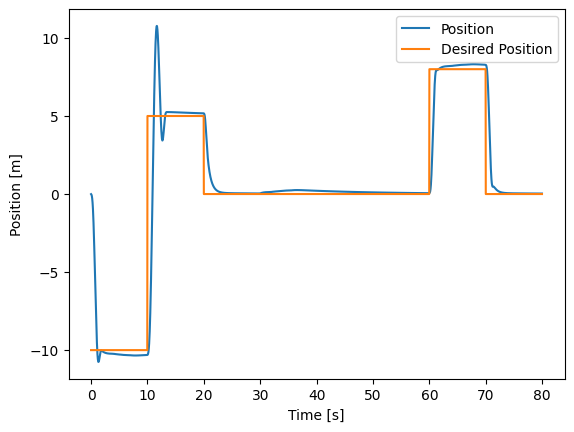

In [30]:
plt.plot(np.arange(len(setpoints)) / fps, best_genome_positions)
plt.plot(np.arange(len(setpoints)) / fps, setpoints)

plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['Position', 'Desired Position'])

plt.show()

In [31]:
def update_plot(generation, show_selection):
    generation_genomes = [genome for genome in all_genomes if genome.generation == generation]
    p = [genome.p for genome in generation_genomes]
    i = [genome.i for genome in generation_genomes]
    d = [genome.d for genome in generation_genomes]
    
    plot_data = {
        'id': [genome.id for genome in generation_genomes],
        'P': p,
        'I': i,
        'D': d,
        'fitness': [genome.fitness for genome in generation_genomes],
        'got_killed': [genome.got_killed for genome in generation_genomes],
        'mutated': [genome.is_mutated for genome in generation_genomes]
    }

    color_map = {True: 'red', False: 'green'}
    symbol_map = {True: 'diamond-open', False: 'circle'}
    fig = px.scatter_3d(
        plot_data, 
        x='P', y='I', z='D', 
        color='got_killed' if show_selection else 'fitness', color_discrete_map=color_map, 
        symbol='mutated', symbol_sequence=[symbol_map[mutated] for mutated in plot_data['mutated']],
        hover_data={'id': True, 'P': True, 'I': True, 'D': True, 'got_killed': True, 'mutated': True}
    )
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[min(np.min(p), p_min), max(np.max(p), p_max)]),
            yaxis=dict(range=[min(np.min(i), i_min), max(np.max(i), i_max)]),
            zaxis=dict(range=[min(np.min(d), d_min), max(np.max(d), d_max)])
        ),
        width=800,
        height=800
    )
    fig.show()

generation_slider = widgets.IntSlider(value=1, min=1, max=num_generations, description='Generation')
show_selection_checkbox = widgets.Checkbox(value=False, description='Show Selection')

interactive_plot = widgets.interactive(update_plot, generation=generation_slider, show_selection=show_selection_checkbox)
display(interactive_plot)

interactive(children=(IntSlider(value=1, description='Generation', max=20, min=1), Checkbox(value=False, descr…

In [42]:
search_id = 1006
genome = next(filter(lambda genome: genome.id == search_id, all_genomes))
visualization = VisualizationFactory.create_visualization(VisualizationType.PID, kp=genome.p, ki=genome.i, kd=genome.d)
visualization.run()